## 04 – Probabilistic forecasts

Quantile regression and conformal prediction intervals.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


from src.data import load_opsd_germany
from src.features import make_features
from src.models import train_point_model, train_quantile_models, predict_quantiles
from src.conformal import compute_absolute_residuals, conformal_interval
from src.evaluation import (
    regression_metrics,
    interval_coverage,
    interval_width,
    quantile_calibration,
    plot_quantile_calibration,
)

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

To start, let's load OPSD Germany, build supervised features for 1-hour-ahead forecasting, and create 60/20/20 train/cal/test splits in chronological order to avoid leakage.


In [2]:
# Load data & create train/cal/test splits
raw = load_opsd_germany(str(PROJECT_ROOT / "data" / "time_series_60min_singleindex.csv"))
X, y = make_features(raw, horizon=1, target_col="load")

# 60/20/20 split by time index
n = len(X)
cutoff_train = X.index[int(0.6 * n)]
cutoff_cal = X.index[int(0.8 * n)]

X_train = X[X.index < cutoff_train]
y_train = y[y.index < cutoff_train]

X_cal = X[(X.index >= cutoff_train) & (X.index < cutoff_cal)]
y_cal = y[(y.index >= cutoff_train) & (y.index < cutoff_cal)]

X_test = X[X.index >= cutoff_cal]
y_test = y[X.index >= cutoff_cal]

X_train.shape, X_cal.shape, X_test.shape


((29958, 28), (9986, 28), (9986, 28))

The printed shapes confirm the sizes of the train, calibration, and test slices. These are used in later cells for model fitting, calibration, and evaluation.


Next, we train gradient boosting models for q=0.1/0.5/0.9 on the training set, then predict conditional quantiles on the test split.


In [3]:
# Quantile regression
quantiles = [0.1, 0.5, 0.9]
q_models = train_quantile_models(X_train, y_train, quantiles=quantiles)
q_preds_test = predict_quantiles(q_models, X_test)
q_preds_test.head()


,q_0.1,q_0.5,q_0.9
utc_timestamp,,,
2019-08-11 21:00:00+00:00,39454.867008,40511.196433,42263.213012
2019-08-11 22:00:00+00:00,38136.997914,38900.165161,40040.052083
2019-08-11 23:00:00+00:00,36986.692763,38033.753090,38730.343768
2019-08-12 00:00:00+00:00,37868.351413,38610.258461,39186.831669
2019-08-12 01:00:00+00:00,38729.861230,38850.220642,39668.434422


Compute empirical coverage of the 80% interval, its average width (sharpness), and point MAE/RMSE from the median forecast.


In [4]:
lower_q = q_preds_test["q_0.1"].values
upper_q = q_preds_test["q_0.9"].values
median_q = q_preds_test["q_0.5"].values

coverage_q = interval_coverage(y_test, lower_q, upper_q)
width_q = interval_width(lower_q, upper_q)
point_metrics_q = regression_metrics(y_test, median_q)

coverage_q, width_q, point_metrics_q


(0.7792910074103745,
 2504.423594775794,
 {'MAE': 685.153112981041, 'RMSE': 965.947009884587})

Coverage close to 80%, indicating good calibration for the target interval

Visualize actuals, the median (q=0.5), and the 80% interval to inspect whether the band captures diurnal peaks and ramps.


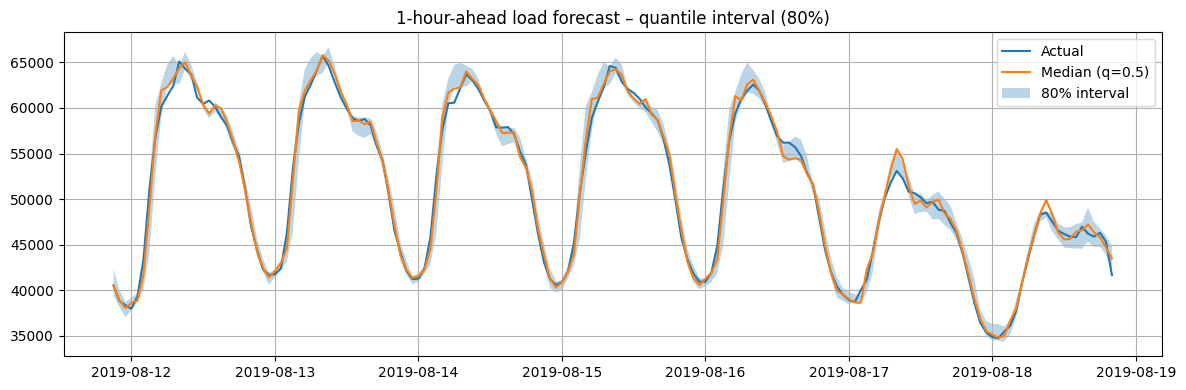

In [5]:
# Plot sample week with quantile band
sample = slice(0, 7 * 24)
time = y_test.index[sample]

plt.plot(time, y_test.values[sample], label="Actual", linewidth=1.5)
plt.plot(time, median_q[sample], label="Median (q=0.5)")
plt.fill_between(time, lower_q[sample], upper_q[sample], alpha=0.3, label="80% interval")

plt.title("1-hour-ahead load forecast – quantile interval (80%)")
plt.legend()
plt.tight_layout()
plt.show()


Notice patterns where interval sits below the observed. These are undercoverage at sharp peaks. There are also over-wide bands in flat periods. This helps judge local calibration and sharpness visually.


Compute the empirical CDF at nominal quantiles (0.1/0.5/0.9) and plot the calibration curve. Closer to the 45° line is better:


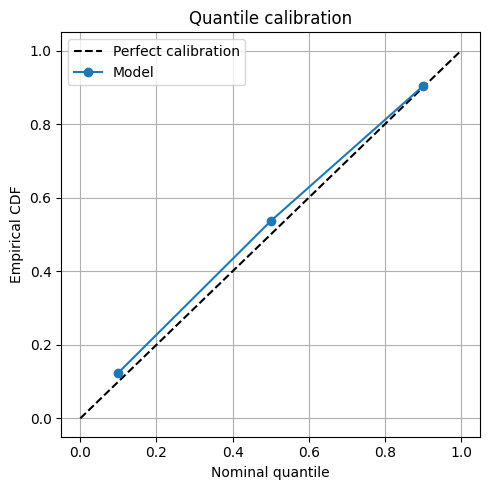

In [6]:
# Quantile calibration plot
calib_df = quantile_calibration(
    y_true=y_test.values,
    q_pred_dict={
        0.1: q_preds_test["q_0.1"].values,
        0.5: q_preds_test["q_0.5"].values,
        0.9: q_preds_test["q_0.9"].values,
    },
)
calib_df
plot_quantile_calibration(calib_df)


The curve sits slightly above the diagonal, especially around q = 0.5, meaning its overpredicting (too high). This helps to spot systematic bias.


Train the point model on the training set and compute absolute residuals on the calibration set. The empirical quantiles of these residuals determine the conformal band size.


In [7]:
# Conformal prediction
point_model = train_point_model(X_train, y_train)
residuals = compute_absolute_residuals(point_model, X_cal, y_cal)
np.quantile(residuals, [0.5, 0.8, 0.9, 0.95])


array([ 463.10774284,  956.29820477, 1299.02289534, 1688.1373201 ])

Now we construct 90% conformal intervals around the point model using calibration residuals, then computes empirical coverage, average width, and point MAE/RMSE on the test split.


In [8]:
# Build conformal intervals on test
alpha = 0.1  # 90% target coverage
lower_conf, upper_conf = conformal_interval(model=point_model, X=X_test, residuals=residuals, alpha=alpha)
y_pred_point_test = point_model.predict(X_test)

coverage_conf = interval_coverage(y_test, lower_conf, upper_conf)
width_conf = interval_width(lower_conf, upper_conf)
point_metrics_conf = regression_metrics(y_test, y_pred_point_test)

coverage_conf, width_conf, point_metrics_conf


(0.8638093330662928,
 2598.045790686476,
 {'MAE': 674.907649951304, 'RMSE': 905.598981028686})

Coverage near 90% indicates well-calibrated intervals; larger widths reflect the higher target coverage. The point metrics (MAE/RMSE) here reflect the underlying point model used by conformal prediction.


This cell assembles a small comparison table for 80% quantile intervals and 90% conformal intervals, reporting coverage, width, and point MAE/RMSE.


In [9]:
# Compare quantile vs conformal
results = pd.DataFrame({
    "method": ["quantile_80", "conformal_90"],
    "coverage": [coverage_q, coverage_conf],
    "avg_width": [width_q, width_conf],
    "MAE": [point_metrics_q["MAE"], point_metrics_conf["MAE"]],
    "RMSE": [point_metrics_q["RMSE"], point_metrics_conf["RMSE"]],
})
results


,method,coverage,avg_width,MAE,RMSE
0,quantile_80,0.779291,2504.423595,685.153113,965.947010
1,conformal_90,0.863809,2598.045791,674.907650,905.598981


Conformal coverage is closer to the 90% target, with wider average widths than the 80% quantile intervals.

Codes below visualize a sample test week showing the point forecast and the 90% conformal prediction band. Use it to qualitatively assess how the interval expands around peaks and unusual patterns.


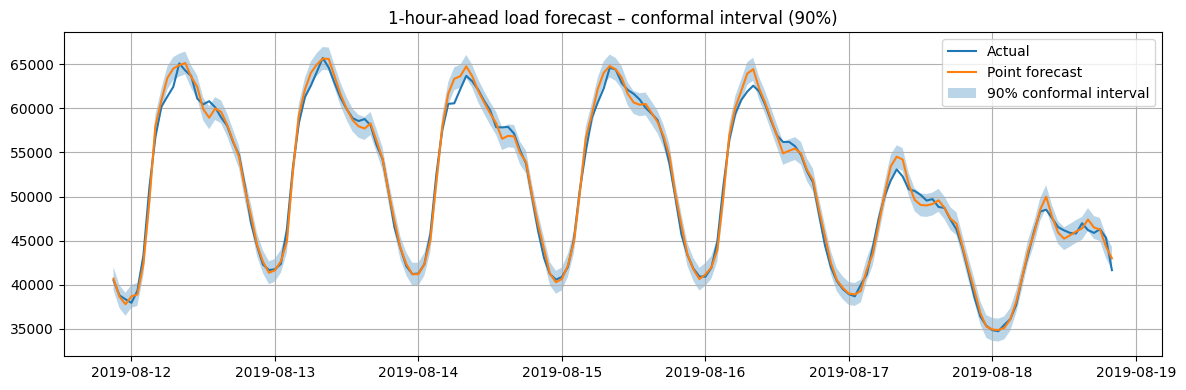

In [10]:
# Plot conformal band for a sample week
sample = slice(0, 7 * 24)
time = y_test.index[sample]

plt.plot(time, y_test.values[sample], label="Actual", linewidth=1.5)
plt.plot(time, y_pred_point_test[sample], label="Point forecast")
plt.fill_between(time, lower_conf[sample], upper_conf[sample], alpha=0.3, label="90% conformal interval")

plt.title("1-hour-ahead load forecast – conformal interval (90%)")
plt.legend()
plt.tight_layout()
plt.show()


The 90% conformal band is slightly wider than the 80% quantile band and more conservative around sharp ramps and peaks.

Now we compute pinball loss for q=0.1/0.5/0.9 on the 1h quantile predictions and reports an average across these quantiles.


In [11]:
# Pinball loss for quantile regression predictions (q=0.1, 0.5, 0.9)
import numpy as np
import pandas as pd
from src.evaluation import pinball_loss

pin_q10 = pinball_loss(y_test.values, q_preds_test["q_0.1"].values, 0.1)
pin_q50 = pinball_loss(y_test.values, q_preds_test["q_0.5"].values, 0.5)
pin_q90 = pinball_loss(y_test.values, q_preds_test["q_0.9"].values, 0.9)

pin_df = pd.DataFrame({
    "quantile": [0.1, 0.5, 0.9],
    "pinball_loss": [pin_q10, pin_q50, pin_q90],
})

pin_df["avg_pinball_3q"] = pin_df["pinball_loss"].mean()
pin_df


,quantile,pinball_loss,avg_pinball_3q
0,0.1,172.268037,226.08381
1,0.5,342.576556,226.08381
2,0.9,163.406836,226.08381


In [12]:
# 24-hour-ahead probabilistic forecasts: data and splits
X_24, y_24 = make_features(raw, horizon=24, target_col="load")

n24 = len(X_24)
cutoff_train_24 = X_24.index[int(0.6 * n24)]
cutoff_cal_24 = X_24.index[int(0.8 * n24)]

X_train_24 = X_24[X_24.index < cutoff_train_24]
y_train_24 = y_24[y_24.index < cutoff_train_24]

X_cal_24 = X_24[(X_24.index >= cutoff_train_24) & (X_24.index < cutoff_cal_24)]
y_cal_24 = y_24[(y_24.index >= cutoff_train_24) & (y_24.index < cutoff_cal_24)]

X_test_24 = X_24[X_24.index >= cutoff_cal_24]
y_test_24 = y_24[X_24.index >= cutoff_cal_24]

X_train_24.shape, X_cal_24.shape, X_test_24.shape


((29944, 28), (9981, 28), (9982, 28))

This trains 24h quantile models, computes 80% interval coverage/width, and pinball losses for q=0.1/0.5/0.9; compares side-by-side with the 1h results.


In [13]:
# 24h quantile regression: coverage, width, and pinball loss
quantiles = [0.1, 0.5, 0.9]
q_models_24 = train_quantile_models(X_train_24, y_train_24, quantiles=quantiles)
q_preds_test_24 = predict_quantiles(q_models_24, X_test_24)

lower_q_24 = q_preds_test_24["q_0.1"].values
upper_q_24 = q_preds_test_24["q_0.9"].values
median_q_24 = q_preds_test_24["q_0.5"].values

coverage_q_24 = interval_coverage(y_test_24, lower_q_24, upper_q_24)
width_q_24 = interval_width(lower_q_24, upper_q_24)

pin_q10_24 = pinball_loss(y_test_24.values, lower_q_24, 0.1)
pin_q50_24 = pinball_loss(y_test_24.values, median_q_24, 0.5)
pin_q90_24 = pinball_loss(y_test_24.values, upper_q_24, 0.9)

summary_24 = pd.DataFrame({
    "horizon": ["1h", "24h"],
    "coverage_80": [coverage_q, coverage_q_24],
    "avg_width_80": [width_q, width_q_24],
    "pinball_q10": [pin_q10, pin_q10_24],
    "pinball_q50": [pin_q50, pin_q50_24],
    "pinball_q90": [pin_q90, pin_q90_24],
})
summary_24


,horizon,coverage_80,avg_width_80,pinball_q10,pinball_q50,pinball_q90
0,1h,0.779291,2504.423595,172.268037,342.576556,163.406836
1,24h,0.776297,6366.062142,522.608567,838.649120,393.781577


Notice reduced coverage for direct quantiles at 24h and larger widths.

This constructs 90% conformal intervals for the 24h horizon and summarizes coverage, width, and point errors against the 80% quantile intervals.


In [14]:
# 24h conformal intervals (target coverage 90%)
point_model_24 = train_point_model(X_train_24, y_train_24)
residuals_24 = compute_absolute_residuals(point_model_24, X_cal_24, y_cal_24)
alpha_24 = 0.1
lower_conf_24, upper_conf_24 = conformal_interval(model=point_model_24, X=X_test_24, residuals=residuals_24, alpha=alpha_24)

y_pred_point_test_24 = point_model_24.predict(X_test_24)

coverage_conf_24 = interval_coverage(y_test_24, lower_conf_24, upper_conf_24)
width_conf_24 = interval_width(lower_conf_24, upper_conf_24)

pd.DataFrame({
    "method": ["quantile_80_24h", "conformal_90_24h"],
    "coverage": [coverage_q_24, coverage_conf_24],
    "avg_width": [width_q_24, width_conf_24],
    "MAE": [regression_metrics(y_test_24, median_q_24)["MAE"], regression_metrics(y_test_24, y_pred_point_test_24)["MAE"]],
    "RMSE": [regression_metrics(y_test_24, median_q_24)["RMSE"], regression_metrics(y_test_24, y_pred_point_test_24)["RMSE"]],
})


,method,coverage,avg_width,MAE,RMSE
0,quantile_80_24h,0.776297,6366.062142,1677.298241,2591.777097
1,conformal_90_24h,0.895812,7312.533579,1773.591801,2578.866372


At 24h, absolute errors and widths increase; conformal typically maintains target coverage better than direct quantiles.


This evaluates coverage and width on the top X% load hours for both horizons, revealing calibration under stress (peak demand).


In [15]:
# Extreme-days slice: evaluate coverage/width on top X% of load
X_percent = 0.05  # top 5% by default

thr_1h = np.quantile(y_test.values, 1 - X_percent)
mask_1h = (y_test.values >= thr_1h)

ext_cov_q_1h = interval_coverage(y_test.values[mask_1h], lower_q[mask_1h], upper_q[mask_1h])
ext_width_q_1h = interval_width(lower_q[mask_1h], upper_q[mask_1h])

ext_cov_conf_1h = interval_coverage(y_test.values[mask_1h], lower_conf[mask_1h], upper_conf[mask_1h])
ext_width_conf_1h = interval_width(lower_conf[mask_1h], upper_conf[mask_1h])

thr_24h = np.quantile(y_test_24.values, 1 - X_percent)
mask_24h = (y_test_24.values >= thr_24h)

ext_cov_q_24h = interval_coverage(y_test_24.values[mask_24h], lower_q_24[mask_24h], upper_q_24[mask_24h])
ext_width_q_24h = interval_width(lower_q_24[mask_24h], upper_q_24[mask_24h])

ext_cov_conf_24h = interval_coverage(y_test_24.values[mask_24h], lower_conf_24[mask_24h], upper_conf_24[mask_24h])
ext_width_conf_24h = interval_width(lower_conf_24[mask_24h], upper_conf_24[mask_24h])

pd.DataFrame({
    "horizon": ["1h", "1h", "24h", "24h"],
    "method": ["quantile_80", "conformal_90", "quantile_80", "conformal_90"],
    "extreme_top_frac": [X_percent]*4,
    "coverage_on_extremes": [ext_cov_q_1h, ext_cov_conf_1h, ext_cov_q_24h, ext_cov_conf_24h],
    "avg_width_on_extremes": [ext_width_q_1h, ext_width_conf_1h, ext_width_q_24h, ext_width_conf_24h],
})


,horizon,method,extreme_top_frac,coverage_on_extremes,avg_width_on_extremes
0,1h,quantile_80,0.05,0.838,2177.070757
1,1h,conformal_90,0.05,0.944,2598.045791
2,24h,quantile_80,0.05,0.788,6569.892573
3,24h,conformal_90,0.05,0.922,7312.533579


Notice lower coverage on extremes for quantile intervals and more stable coverage for conformal; widths generally increase on extreme hours.


This plots the highest-load week in the test set with both 80% quantile and 90% conformal bands for a direct visual comparison around the peak.


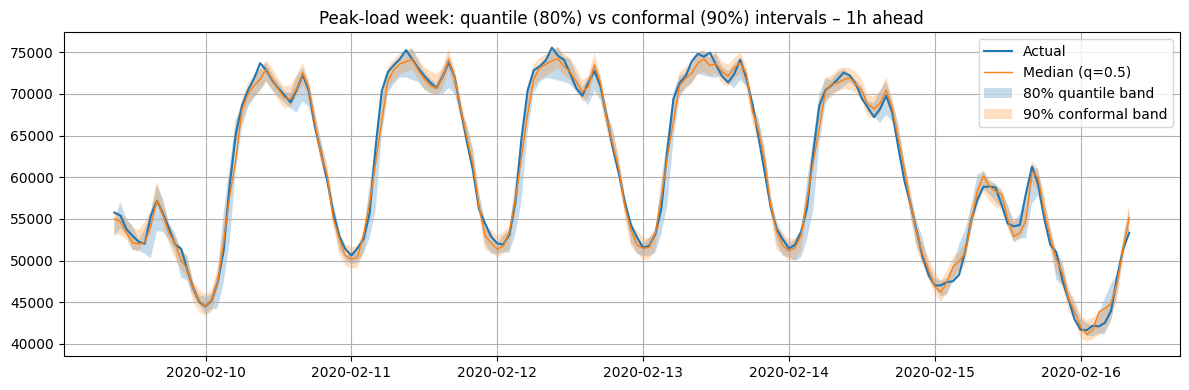

In [16]:
# Plot a peak-load week with intervals (1h horizon)
peak_idx = int(np.argmax(y_test.values))
start_idx = max(0, peak_idx - 3*24)
end_idx = min(len(y_test), peak_idx + 4*24)
sl = slice(start_idx, end_idx)

plt.figure(figsize=(12, 4))
plt.plot(y_test.index[sl], y_test.values[sl], label="Actual", lw=1.5)
plt.plot(y_test.index[sl], median_q[sl], label="Median (q=0.5)", lw=1.0)
plt.fill_between(y_test.index[sl], lower_q[sl], upper_q[sl], alpha=0.25, label="80% quantile band")
plt.fill_between(y_test.index[sl], lower_conf[sl], upper_conf[sl], alpha=0.25, label="90% conformal band")
plt.title("Peak-load week: quantile (80%) vs conformal (90%) intervals – 1h ahead")
plt.legend()
plt.tight_layout()
plt.show()


Conformal bands expand more than quantile bands near the peak.

This computes coverage and widths by hour of day for both 80% quantile and 90% conformal intervals, plus widths normalized by median load.


In [17]:
# Hour-of-day coverage and normalized interval widths (1h horizon)
hour_idx = y_test.index.hour.values

# Quantile 80% by hour
df_hour_q = pd.DataFrame({
    "hour": hour_idx,
    "y": y_test.values,
    "lower": lower_q,
    "upper": upper_q,
})

cov_by_hour_q = df_hour_q.groupby("hour").apply(lambda g: interval_coverage(g["y"].values, g["lower"].values, g["upper"].values))
width_by_hour_q = df_hour_q.groupby("hour").apply(lambda g: interval_width(g["lower"].values, g["upper"].values))

# Conformal 90% by hour
df_hour_c = pd.DataFrame({
    "hour": hour_idx,
    "y": y_test.values,
    "lower": lower_conf,
    "upper": upper_conf,
})

cov_by_hour_c = df_hour_c.groupby("hour").apply(lambda g: interval_coverage(g["y"].values, g["lower"].values, g["upper"].values))
width_by_hour_c = df_hour_c.groupby("hour").apply(lambda g: interval_width(g["lower"].values, g["upper"].values))

median_load = float(np.median(y_test.values))
summary_hour = pd.DataFrame({
    "cov_q80": cov_by_hour_q,
    "cov_conf90": cov_by_hour_c,
    "width_q80": width_by_hour_q,
    "width_conf90": width_by_hour_c,
})
summary_hour["width_q80_norm"] = summary_hour["width_q80"] / median_load
summary_hour["width_conf90_norm"] = summary_hour["width_conf90"] / median_load
summary_hour.sort_index()


/var/folders/zp/85klwk4938514ydsph5grv3m0000gq/T/ipykernel_61817/2944454099.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cov_by_hour_q = df_hour_q.groupby("hour").apply(lambda g: interval_coverage(g["y"].values, g["lower"].values, g["upper"].values))
/var/folders/zp/85klwk4938514ydsph5grv3m0000gq/T/ipykernel_61817/2944454099.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  width_by_hour_q = df_hour_q.grou

,cov_q80,cov_conf90,width_q80,width_conf90,width_q80_norm,width_conf90_norm
hour,,,,,,
0,0.826923,0.997596,1299.012271,2598.045791,0.024315,0.04863
1,0.831731,0.983173,1545.108124,2598.045791,0.028921,0.04863
2,0.740385,0.887019,2918.632814,2598.045791,0.054631,0.04863
3,0.824519,0.610577,6074.054619,2598.045791,0.113694,0.04863
4,0.867788,0.721154,6426.590640,2598.045791,0.120293,0.04863
5,0.860577,0.776442,3764.992609,2598.045791,0.070473,0.04863
6,0.644231,0.685096,2750.023493,2598.045791,0.051475,0.04863
7,0.718750,0.699519,2588.274943,2598.045791,0.048447,0.04863
8,0.819712,0.713942,2376.853900,2598.045791,0.044490,0.04863


Use these to identify times of day with under/over-coverage and to compare sharpness on a relative scale.


This computes an average pinball loss over a grid of quantiles, serving as a CRPS-style summary of distributional accuracy.


In [18]:
# CRPS-style approximation via average pinball over a quantile grid (1h horizon)
q_grid = np.linspace(0.05, 0.95, 19)
q_grid_models = train_quantile_models(X_train, y_train, quantiles=list(q_grid))
q_grid_preds = predict_quantiles(q_grid_models, X_test)

# Compute average pinball across the grid
pinball_values = []
for q in q_grid:
    col = f"q_{q}"
    pinball_values.append(pinball_loss(y_test.values, q_grid_preds[col].values, float(q)))

crps_like_avg_pinball_1h = float(np.mean(pinball_values))

pd.DataFrame({
    "metric": ["avg_pinball_over_grid"],
    "value": [crps_like_avg_pinball_1h],
})


,metric,value
0,avg_pinball_over_grid,270.669939


Lower values indicate better distributional fit; compare across model variants or horizons to assess improvements.


### Notes on features

Current probabilistic runs use engineered time-series features derived from load/solar/wind and calendar variables. Weather predictors (e.g., temperature) are not included in these results. If available, temperature or other meteorological features can be merged on timestamp and added to the feature pipeline to assess their impact on calibration and sharpness.
